# Introduction to Machine Learning

**Wikipedia definition:** "Machine learning (ML) is the scientific study of algorithms and statistical models that computer systems use to effectively perform a specific task without using explicit instructions, relying on patterns and inference instead."

**Misconception:** "Machine learning is based on the idea that we can build machines to process data and learn on their own, without our constant supervision."

![python-scistack](https://qph.fs.quoracdn.net/main-qimg-50a207036007b41f563c6f8aadfc1266.webp)


The following classification in ML highlights the data utilized during training:

**Unsupervised:** Given training data $x$, we learn its probability distribution

$$ \large p(x). $$

**Supervised:** Given training data $x$ and associated labels $y$, we learn one of the following distributions

$$ \large p(x, \ y) \ \text{or} \ p(y | x).$$  




**Classification of ML Algorithms:**

![python-scistack](https://i1.wp.com/blog.kaggle.com/wp-content/uploads/2015/04/drop_shadows_background2.png)

**Regression:**
<li> Moving averages </li>
<li> Least squares </li>
<li> Gaussian process </li>



![python-scistack](https://blogs.mathworks.com/images/loren/261/RWLOWESS_04.png)

**Classification**
<li> Nearest neighbor </li>
<li> Naive Bayes </li>
<li> Logistic regression </li>
<li> Decision trees </li>
<li> Support vector machines (SVM) </li>

![python-scistack](https://cdn-images-1.medium.com/max/1600/1*zWzeMGyCc7KvGD9X8lwlnQ.png)

**Clustering**
<li> K-means </li>
<li> Hierarchical </li>
<li> DBSCAN </li>
<li> Gaussian mixture model (GMM) </li>


![python-scistack](http://biomedicalcomputationreview.org/sites/default/files/imagecache/article-inline-image/u38/17summerp41.png)

**Dimensionality Reduction**
<li> Principal component analysis (PCA) </li>
<li> Latent semantic analysis (LSA) </li>
<li> Non-negative matrix factorization (NMF) </li>
<li> PageRank </li>


![python-scistack](https://i.stack.imgur.com/gZMOV.png)

**Underfitting vs. Overfitting:**

![python-scistack](https://image.slidesharecdn.com/dlai2017d6l2methodology-171113090926/95/methodology-dlai-d6l2-2017-upc-deep-learning-for-artificial-intelligence-12-638.jpg?cb=1510564325)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from skimage.morphology import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

from scipy.ndimage.filters import convolve

import seaborn as sb

from sklearn.mixture import GaussianMixture

from mnist import MNIST


In [2]:
# Load data (numpy array)
height_data = np.load("ml_image.npy")


In [3]:
# Set up side-by-side comparison plot
def show_images(I0, I1, cmap0='viridis', cmap1='viridis'):
    plt.figure(figsize=(20,20))
    
    plt.subplot(1,2,1)
    m = plt.imshow(I0, cmap=cmap0)
    plt.colorbar(m, fraction=0.046, pad=0.04)

    plt.subplot(1,2,2)
    m = plt.imshow(I1, cmap=cmap1)
    plt.colorbar(m, fraction=0.046, pad=0.04)


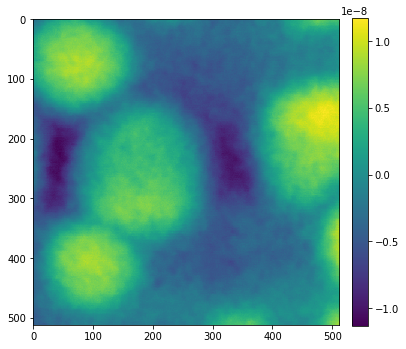

In [4]:
# Plot raw data
plt.figure(figsize=(6,6))
plt.imshow(height_data)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()


## Method 1: Simple Threshold

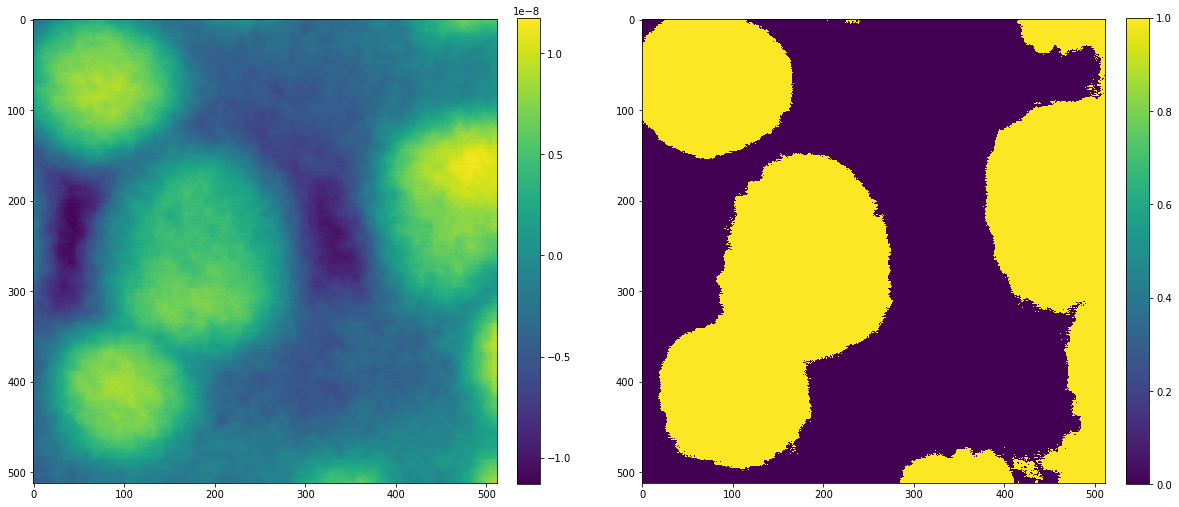

In [5]:
# Binarize data
binary_data = height_data > 0
binary_data = binary_data.astype(np.int)
show_images(height_data, binary_data)


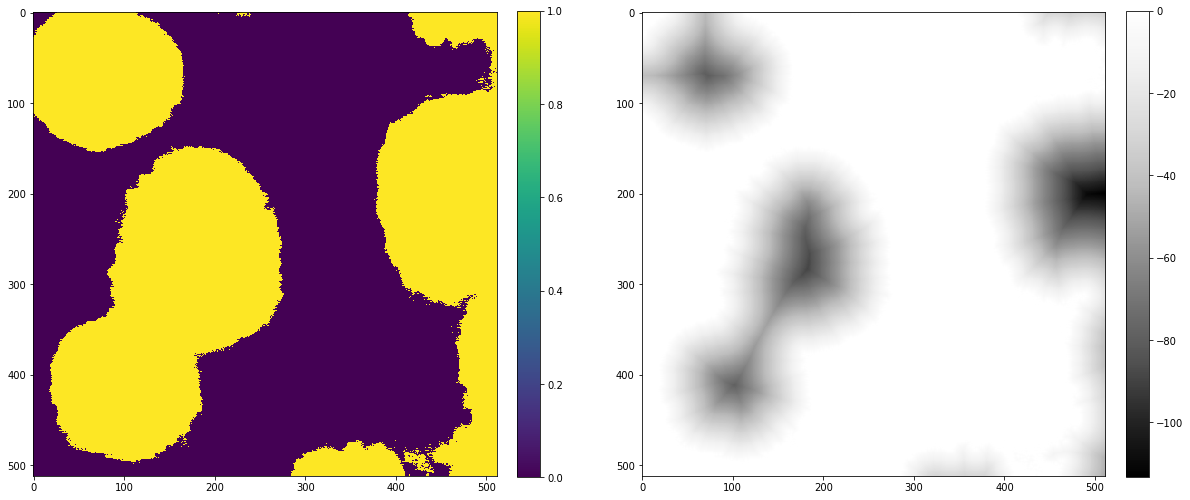

In [6]:
# Compute distance to boundary
distance = ndi.distance_transform_edt(binary_data)
show_images(binary_data, -distance, cmap1='Greys_r')


In [7]:
# Identify maxima
k = 5
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((k, k)))
markers = ndi.label(local_maxi)[0]


**Watershed Algorithm**

![python-scistack](https://svi.nl/dl1502?display&x=352&y=200)

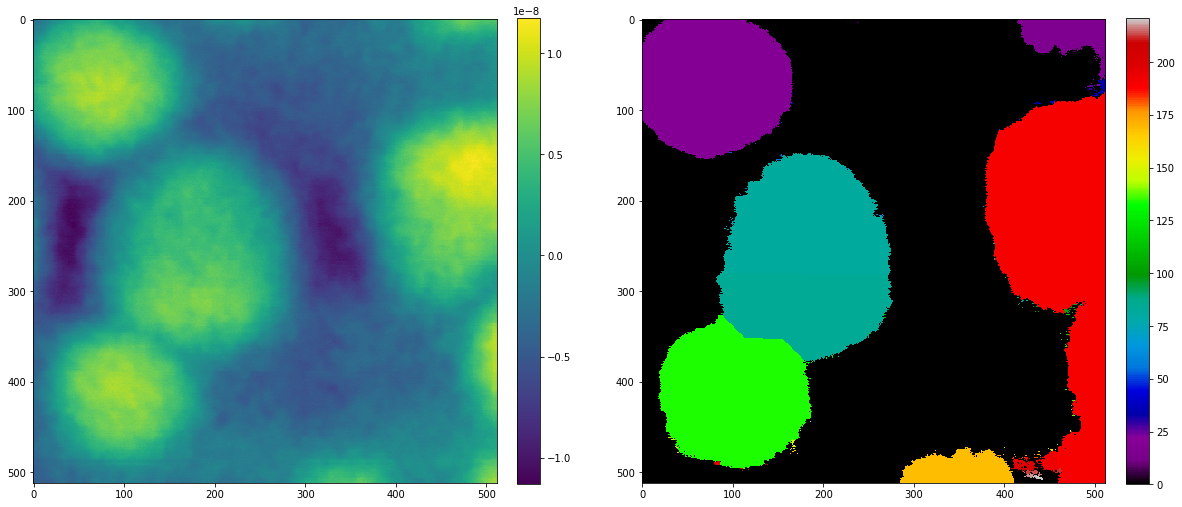

In [8]:
# Apply watershed algorithm
labels = watershed(-distance, markers, mask=binary_data)
show_images(height_data, labels, cmap1='nipy_spectral')


## Method 2: Smooth and Sharpen

Smoothing Filter:

<center>
    $\large K=\frac{1}{9}\cdot\left(\begin{array}{ccc}1&1&1\\1&1&1\\1&1&1\end{array}\right)$
</center>

Sharpening Filter: 

$$\large K = \left[\begin{array}{ccc}0&-1&0\\-1&5&-1\\0&-1&0\end{array}\right]$$

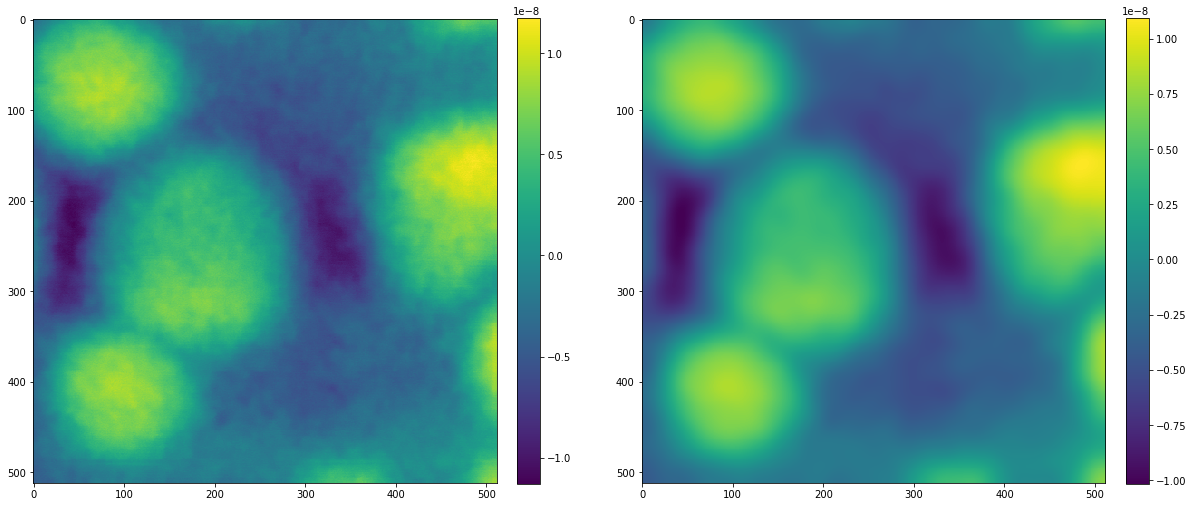

In [9]:
# Smooth and sharpen data
K_smooth = np.ones(shape=(15,15)) / 225
K_sharp = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

I = convolve(height_data, K_smooth, mode="reflect")
I = convolve(I, K_sharp, mode="reflect")
I = convolve(I, K_smooth, mode="reflect")
I = convolve(I, K_sharp, mode="reflect")
I = convolve(I, K_smooth, mode="reflect")
I = convolve(I, K_sharp, mode="reflect")
I = convolve(I, K_smooth, mode="reflect")
I = convolve(I, K_sharp, mode="reflect")

show_images(height_data, I)


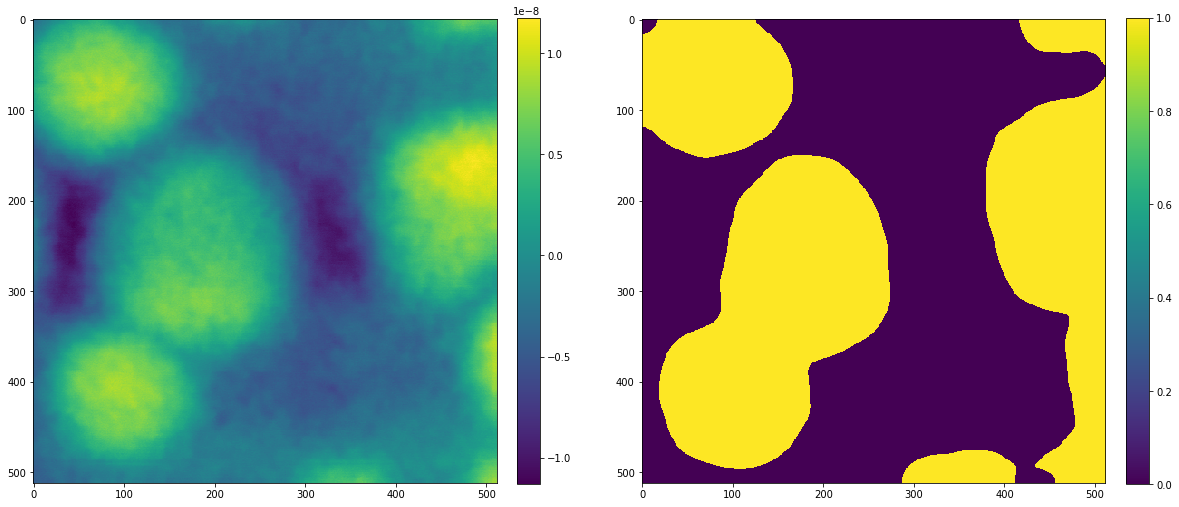

In [11]:
# Binarize data
sharpen_binary_data = I > 0
sharpen_binary_data = sharpen_binary_data.astype(np.int)
show_images(height_data, sharpen_binary_data)


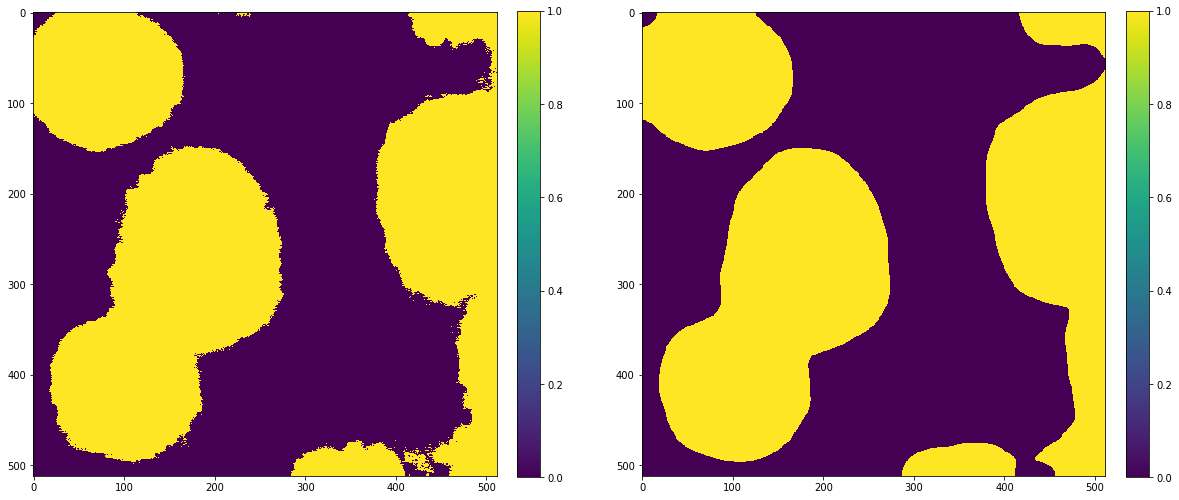

In [12]:
show_images(binary_data, sharpen_binary_data)


## Method 3: Gaussian Mixture Model

**GMM:** We model the distribution of the training data $\large \{x_j \}_{j=1}^N$ as a convex sum of Gaussian kernels

$$\large p(x) = \sum_{i=1}^K \phi_i \mathcal{N}(x|\mu_i, \sigma_i) $$
where

$$\large \mathcal{N}(x|\mu_i, \sigma_i) = \frac{1}{\sigma_i \sqrt{2\pi}} \exp \left (- \frac{(x-\mu_i)^2}{2\sigma_i^2} \right )$$
and

$$\large \sum_{i=1}^K \phi_i = 1. $$

**Learning:** We use the expectation maximization (EM) algorithm to learn the underlying probability density function.

**Initialization:**
Initialize the parameters $\large \{\mu_i\}_{i=1}^K$ (random training values), $\large \{\sigma_i\}_{i=1}^K$ (sample variance), and $\large \{\phi_i\}_{i=1}^K$ (equally likely). 

**Expectation:** 
Compute the likelihood that data point $\large x_j$ is generated by component $\large C_k$

$$\large \gamma_{j,k} = p(C_k | x_j, \phi_k, \mu_k, \sigma_k) = \frac{\phi_k \mathcal{N}(x_j | \mu_k, \sigma_k)}{\sum_{i=1}^{K} \phi_i \mathcal{N}(x_j | \mu_i, \sigma_i)}. $$

**Maximization:**
Update the model parameters

$$\large \phi_k = \sum_{j=1}^N \frac{\gamma_{j,k}}{N}, $$

$$\large \mu_k = \frac{\sum_{j=1}^N \gamma_{j,k}x_j}{\sum_{j=i}^N \gamma_{j,k}}, $$
and

$$\large \sigma_k = \frac{\sum_{j=1}^N \gamma_{j,k} (x_j - \mu_k)^2}{\sum_{j=1}^N \gamma_{j,k}}.$$ 

**Convergence:** Repeat EM steps until convergence criteria is satisfied.

**Clustering:** 
The probability of data point $x$ belongs to component $\large C_k$ is given by,

$$\large p(C_k|x) = \frac{p(x, C_k)}{p(x)} = \frac{p(C_k)p(x|C_k)}{\sum_{i=1}^K p(C_i) p(x | C_i)} = \frac{\phi_k \mathcal{N}(x |\mu_i, \sigma_i)}{\sum_{i=1}^K \phi_i \mathcal{N}(x | \mu_i, \sigma_i)}.$$



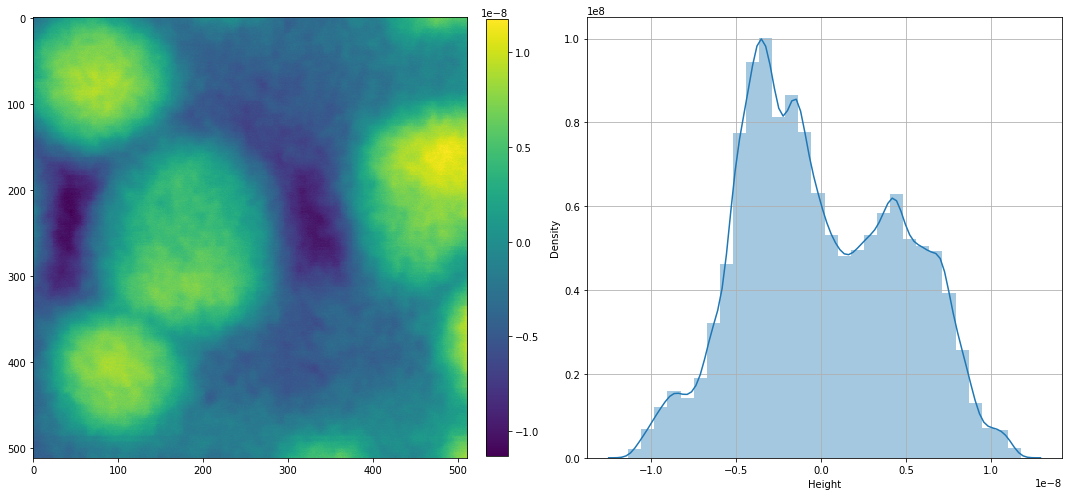

In [13]:
# Show a-priori distribution
h, w = height_data.shape
vector_data = height_data.reshape(h*w,1)
plt.figure(figsize=(15,7))
    
plt.subplot(1,2,1)
m = plt.imshow(height_data, aspect='auto')
plt.colorbar(m, fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
sb.distplot(vector_data, 30)
plt.grid()
plt.xlabel('Height')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [14]:
# Normalize data
abs_max = np.max(np.abs(vector_data))
normalized_vector_data = vector_data / abs_max


In [15]:
# Train GMM
gmm = GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(normalized_vector_data)
vector_labels = gmm.predict(normalized_vector_data)
labels = vector_labels.reshape(h, w)


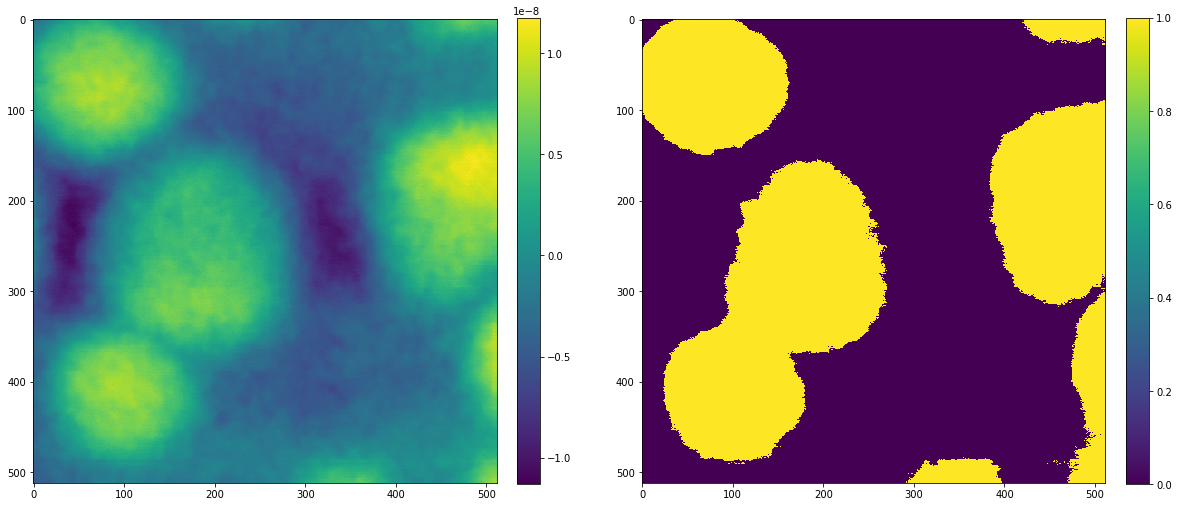

In [16]:
# Show GMM predictions
# NOTE: This forces the labels to match previous methods
unique_labels = sorted(np.unique(labels), key=lambda k: np.sum(labels==k), reverse=True)
sorted_labels = np.copy(labels)
for i, l in enumerate(unique_labels):
    sorted_labels[labels==l] = i

show_images(height_data, sorted_labels) # Left: Raw data. Right: GMM classification.


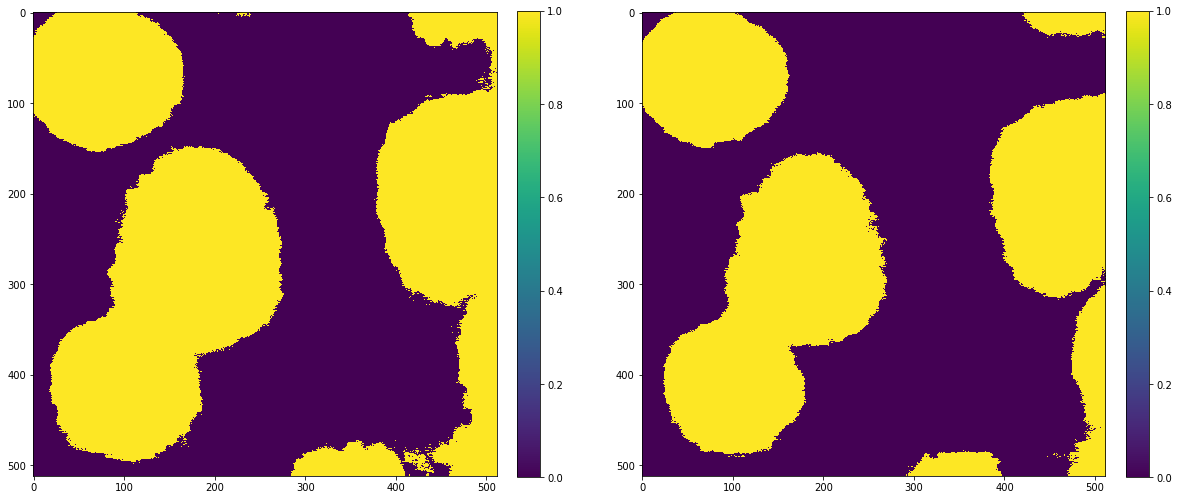

In [17]:
# Compare GMM predictions to simple method predictions
show_images(binary_data, sorted_labels) # Left: Simple threshold. Right: GMM classification.


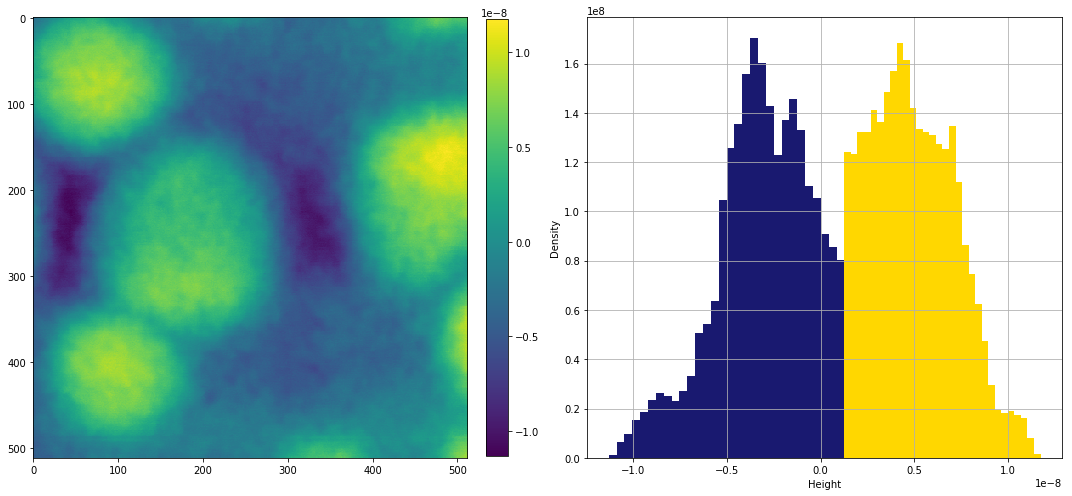

In [18]:
# Show distributions of GMM classification
plt.figure(figsize=(15,7))
    
plt.subplot(1,2,1)
m = plt.imshow(height_data, aspect='auto')
plt.colorbar(m, fraction=0.046, pad=0.04)

plt.subplot(1,2,2) 
plt.hist(height_data[sorted_labels == 0], 30, color='midnightblue', alpha=1, density=True)
plt.hist(height_data[sorted_labels == 1], 30, color='gold', alpha=1, density=True)

plt.xlabel('Height')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()
plt.show()


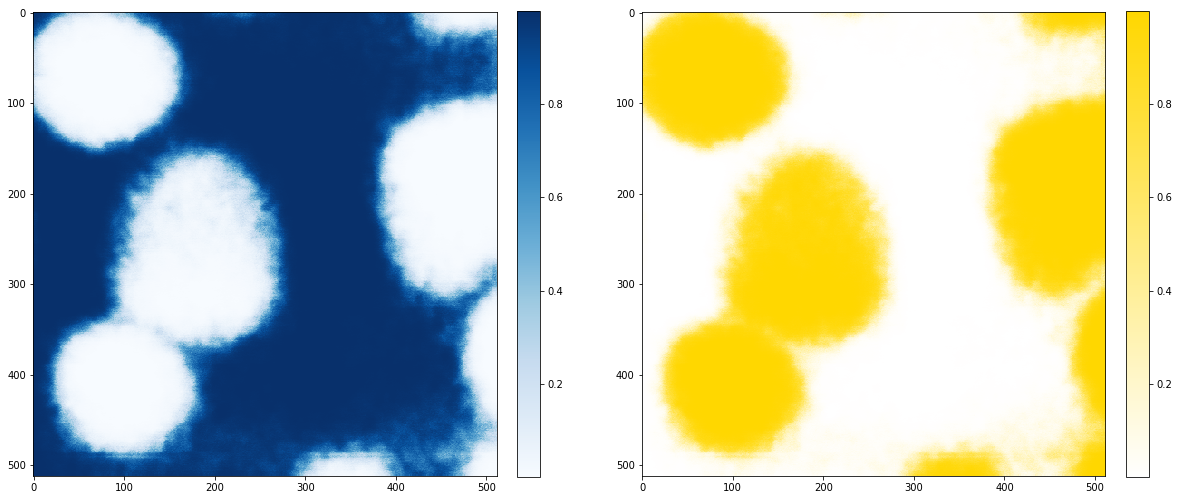

In [19]:
# Show GMM distributions overlaid on raw data
vector_probs = gmm.predict_proba(normalized_vector_data)
class_a = vector_probs[:, 0]
labels_a = class_a.reshape(h, w)
class_b = vector_probs[:, 1]
labels_b = class_b.reshape(h, w)

mycmap = LinearSegmentedColormap.from_list('mycmap', ['white', 'gold'])
show_images(labels_b, labels_a, cmap0="Blues", cmap1=mycmap)


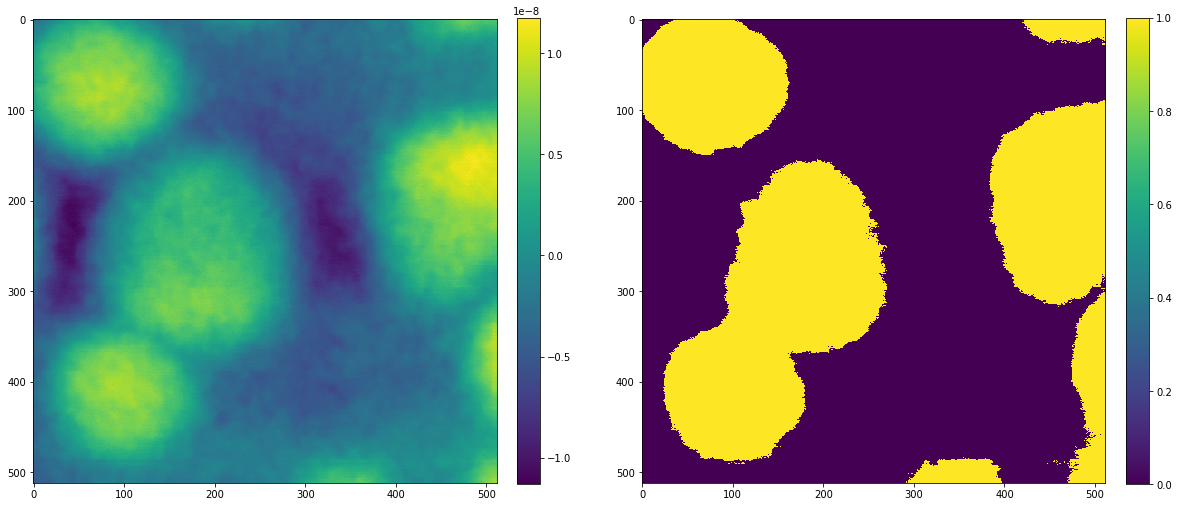

In [20]:
# How to improve the classification? What are the features?
show_images(height_data, sorted_labels)

## Handling MNIST dataset

Run the following commands in your terminal to download the MNIST dataset
<li> pip install python-mnist </li>
<li> git clone https://github.com/sorki/python-mnist </li>
<li> cd python-mnist </li>
<li> ./get_data.sh </li>

In [21]:
# Get MNIST data
mndata = MNIST("./python-mnist/data")
images, labels = mndata.load_training()


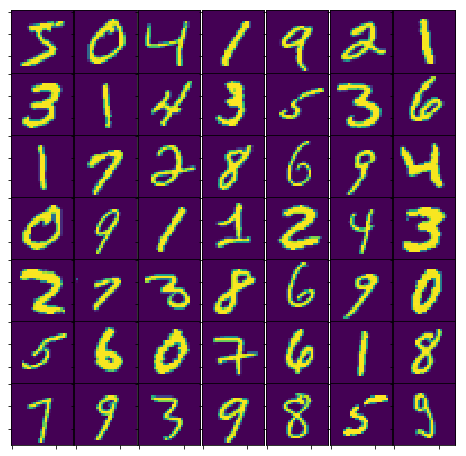

In [22]:
# Show samples of MNIST data
plt.figure(figsize=(8,8))
for i in range(49):    
    ax = plt.subplot(7,7,i+1)
    image = np.array(images[i])
    image = image.reshape(28, 28)
    ax.imshow(image)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [23]:
# Set up train/test data split
num_training_data = int(2 / 3 * len(images))

min_label = min(labels)
max_label = max(labels)

images_train = images[:num_training_data]
labels_train = labels[:num_training_data]
images_test = images[num_training_data:]
labels_test = labels[num_training_data:]

n = len(images_train) # number of data points
n_test = len(images_test)
nf = len(images_train[0]) # number of features
nc = len(range(min_label, max_label + 1)) # number of classes

print(f"Total number of training data points is {n}")
print(f"Total number of testing data points is {n_test}")
print(f"Total number of data features is {nf}")
print(f"Total number of classes is {nc}")

# Create training label matrix
C = np.zeros((nc, n)) # nc x n
for i in range(n):
    l = labels_train[i]
    C[l, i] = 1

# Create testing label matrix
C_test = np.zeros((nc, n_test))
for i in range(n_test):
    l = labels_test[i]
    C_test[l, i] = 1

# Set up training data matrix with bias
X = np.vstack([np.array(images_train).T, np.ones((1, n))]) # (nf + 1) x n

# Set up testing data matrix with bias
X_test = np.vstack([np.array(images_test).T, np.ones((1, n_test))]) # (nf + 1) x n_test


Total number of training data points is 40000
Total number of testing data points is 20000
Total number of data features is 784
Total number of classes is 10


## Linear Least Squares

**Set up:** Given data samples $\large \{ x_i \}_{i=1}^n$ where $ \large x_i \in \mathbb{R}^{n_f}$ and labels $ \large \{ c_i \}_{i=1}^n$ where $\large c_i \in \mathbb{R}^{n_c}$. We want to learn a function such that 

$$\large  f(X) = C, $$

where $\large X \in \mathbb{R}^{n_f x n} $ and $\large C \in \mathbb{R}^{n_c x n}$. 

**Linear least squares:** We assume $\large f$ is a linear model, i.e., 

$$\large f(X; W, b) = X^T W + e_n b^T, $$

where $\large W \in \mathbb{R}^{n_f x n_c}$, $\large b\in \mathbb{R}^{n_c}$, and $\large e_n \in \mathbb{R}^{n}.$ We can simplify the above expression as 

$$ \large  f(\hat X; \hat W) = \hat X^T \hat W, $$

where $\large \hat X \in \mathbb{R}^{(n_f + 1) x n}$ and $\large \hat W \in \mathbb{R}^{(n_f + 1)x n_c}$. Thus, we want to minimize the residuals

$$ \large  \min_{W} \ \frac{1}{2} \| \hat X^T \hat W - C^T \|^2_F . $$

**Learning:** This problem can be solved explicitly using normal equations

$$ \large \hat X \hat X^T \hat W = \hat X C^T. $$

**Condition number:** The condition number of matrix $A$ is

$$ \large \kappa(A) = \| A \| \| A^{-1} \| .$$

**Regularization:** We add a regularization term to deal with the ill-conditioned matrix $\hat X$

$$ \large  \min_{W} \ \frac{1}{2} \| \hat X^T \hat W - C^T \|^2_F + \frac{\lambda}{2} \| \hat W \|^2_F. $$

The regularized problem can also be solved explicitly using normal equations

$$ \large (\hat X \hat X^T + \lambda I_n ) \ \hat W = \hat X C^T. $$



In [24]:
# Normal equations with regularization to improve condition number of A'A
XX = X @ X.T
cond = np.linalg.cond(XX)
print(f"Condition number of XX' before regularization is {cond}")

# Regularization
lamb = 1
XX += lamb * np.diag(np.ones(nf + 1))
cond = np.linalg.cond(XX)
print(f"Condition number of XX' after regularization is {cond}")

# Solving for least squares weights
XX_inv = np.linalg.inv(XX)
XC = X @ C.T
W = XX_inv @ XC # (nf + 1) x nc


Condition number of XX' before regularization is inf
Condition number of XX' after regularization is 100301939935.70956


In [25]:
# Set up accuracy computation
def compute_accuracy(X, W, C, n):
    # Comparing classification
    true_c = C.T # n_test x nc
    pred_c = X.T @ W # n_test x nc

    num_correct = 0
    for i in range(n):
        true_label = np.argwhere(true_c[i,:] == 1)[0][0]
        pred_label = np.argmax(pred_c[i,:])
        if true_label == pred_label:
            num_correct += 1
    
    print(f"Total number of samples: {n}")
    print(f"Total number of correctly classified samples: {num_correct}")
    print(f"Model accuracy: {np.round(num_correct / n * 100, 2)}")
    

In [26]:
# Get accuracy from train data
print('Training Accuracy:')
compute_accuracy(X, W, C, n)
print('-'*50)

# Get accuracy from test data
print('Testing Accuracy:')
compute_accuracy(X_test, W, C_test, n_test)


Training Accuracy:
Total number of samples: 40000
Total number of correctly classified samples: 34377
Model accuracy: 85.94
--------------------------------------------------
Testing Accuracy:
Total number of samples: 20000
Total number of correctly classified samples: 17096
Model accuracy: 85.48


## Next Seminar: Deep Learning

Read Alexnet paper https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

and blog post https://swethatanamala.github.io/2018/06/23/summary-of-alexnet-paper/